In [1]:
# verify kernel
import sys
print(sys.executable)

/home/slwp1/work/testing123/susan/.venv/bin/python


In [2]:
# import libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# use samples from https://vision.middlebury.edu/stereo/data/scenes2021/
img1 = cv2.imread("img0.jpg")
img2 = cv2.imread("img1.jpg")

# Convert to grayscale
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

In [6]:
# feature detection
# find distinctive points that appear in both images
# use ORB
orb = cv2.ORB_create(nfeatures=2000)

kp1, des1 = orb.detectAndCompute(gray1, None)
kp2, des2 = orb.detectAndCompute(gray2, None)

print(len(kp1), len(kp2))

1294 1508


(np.float64(-0.5), np.float64(383.5), np.float64(215.5), np.float64(-0.5))

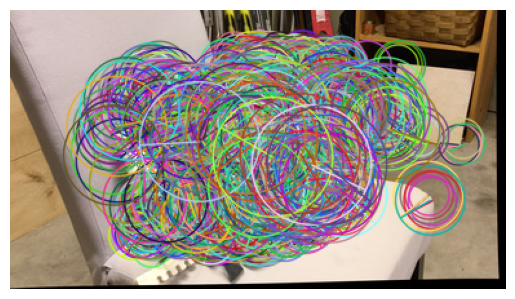

In [7]:
# visual sanity check 
vis1 = cv2.drawKeypoints(img1, kp1, None,
                          flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.imshow(vis1[:,:,::-1])
plt.axis("off")

In [8]:
# feature matching with Hamming + ratio test 
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
matches = bf.knnMatch(des1, des2, k=2)

good = []
pts1 = []
pts2 = []

for m, n in matches:
    if m.distance < 0.8 * n.distance:   # Lowe ratio test
        good.append(m)
        pts1.append(kp1[m.queryIdx].pt)
        pts2.append(kp2[m.trainIdx].pt)

pts1 = np.array(pts1)
pts2 = np.array(pts2)

print("Good matches:", len(good))

Good matches: 25


(np.float64(-0.5), np.float64(767.5), np.float64(215.5), np.float64(-0.5))

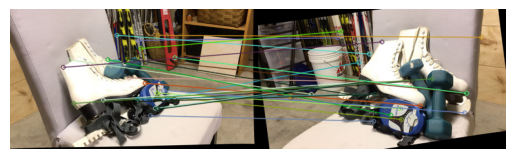

In [9]:
# visual check again to see those 25 good matches
match_img = cv2.drawMatches(
    img1, kp1, img2, kp2, good, None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

plt.imshow(match_img[:,:,::-1])
plt.axis("off")

In [ ]:
# undistort points
# removing lens distortion before geometry
# ensure correct shapes/dtypes 

# Susan's notes
i need to go back to lab03 so, i skipped/ alter some parts for now
- what i understand is that to compute Essential Matrix E we need camera intrinsics K and well, the distortion things to continue
- rn if i were to continue exactly like lab05 notebook i need to go back to lab03 and compute those
- i will just use Fundamental Matrix F which works with pixel points and no callibration needed so that I can visualize epipolar geometry
- i will try the full 3D with matrix E later again


In [11]:
# define matched points properly 
matched1 = pts1.astype(np.float32)
matched2 = pts2.astype(np.float32)
print("matched1 shape:", matched1.shape, "matched2 shape:", matched2.shape)

matched1 shape: (25, 2) matched2 shape: (25, 2)


In [12]:
# estimate F with RANSAC
F, maskF = cv2.findFundamentalMat(matched1, matched2, cv2.FM_RANSAC, 1.0, 0.999)
if F is None:
    raise RuntimeError("findFundamentalMat failed (too few/too noisy matches).")

maskF = maskF.ravel().astype(bool)
p1 = matched1[maskF]
p2 = matched2[maskF]
print("F inliers:", p1.shape[0])
print("F:\n", F)

F inliers: 11
F:
 [[ 2.11930983e-05  3.04365919e-05 -6.85305456e-03]
 [-2.31075943e-05  2.07747531e-05  9.53529272e-04]
 [-1.39607021e-03 -6.54596974e-03  1.00000000e+00]]


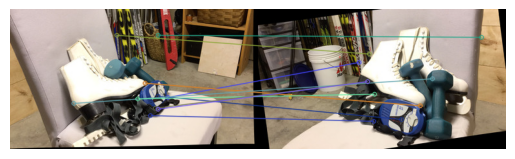

In [13]:
# visualize inlier matches
inlier_matches = [good[i] for i, keep in enumerate(maskF) if keep]
match_inliers_img = cv2.drawMatches(img1, kp1, img2, kp2, inlier_matches, None,
                                    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(match_inliers_img[:,:,::-1]); plt.axis("off");

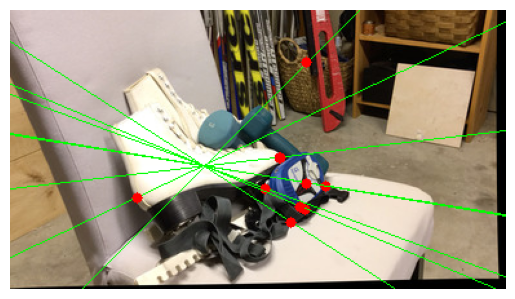

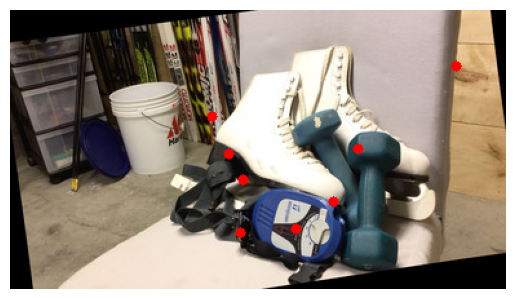

In [14]:
# draw epipolar lines 
def draw_epilines(imgA, imgB, linesA, ptsA, ptsB, n=10):
    imgA = imgA.copy()
    imgB = imgB.copy()

    h, w = imgA.shape[:2]
    idx = np.random.choice(len(ptsA), size=min(n, len(ptsA)), replace=False)

    for i in idx:
        r = linesA[i]
        a, b, c = r
        # line: ax + by + c = 0
        x0, y0 = 0, int(-c / b) if abs(b) > 1e-6 else 0
        x1, y1 = w, int(-(c + a*w) / b) if abs(b) > 1e-6 else h

        cv2.line(imgA, (x0, y0), (x1, y1), (0,255,0), 1)
        cv2.circle(imgA, tuple(ptsA[i].astype(int)), 4, (0,0,255), -1)
        cv2.circle(imgB, tuple(ptsB[i].astype(int)), 4, (0,0,255), -1)

    return imgA, imgB

# Lines in image1 corresponding to points in image2:
lines1 = cv2.computeCorrespondEpilines(p2.reshape(-1,1,2), 2, F).reshape(-1,3)
img1_lines, img2_pts = draw_epilines(img1, img2, lines1, p1, p2, n=10)

plt.imshow(img1_lines[:,:,::-1]); plt.axis("off");
plt.figure()
plt.imshow(img2_pts[:,:,::-1]); plt.axis("off");

In [17]:
# improve correspondences with correctMatches
# p1, p2 are inlier points after findFundamentalMat, shape (N,2)
p1 = p1.astype(np.float32).reshape(1, -1, 2)
p2 = p2.astype(np.float32).reshape(1, -1, 2)

print("p1 shape:", p1.shape, "p2 shape:", p2.shape)  # should be (1,N,2)

p1c, p2c = cv2.correctMatches(F, p1, p2)  # returns (1,N,2)

# back to (N,2)
p1c = p1c.reshape(-1, 2)
p2c = p2c.reshape(-1, 2)

print("Corrected points:", p1c.shape, p2c.shape)

p1 shape: (1, 11, 2) p2 shape: (1, 11, 2)
Corrected points: (11, 2) (11, 2)


In [18]:
# build canon projection matrices from F
def skew(v):
    x, y, z = v.ravel()
    return np.array([[0, -z,  y],
                     [z,  0, -x],
                     [-y, x,  0]], dtype=float)

# Compute epipole e' as null space of F^T (F^T e' = 0)
U, S, Vt = np.linalg.svd(F.T)
e2 = Vt[-1]
e2 = e2 / e2[2]  # normalize so last coord = 1

P1 = np.hstack([np.eye(3), np.zeros((3,1))])
P2 = np.hstack([skew(e2) @ F, e2.reshape(3,1)])

print("P1:\n", P1)
print("P2:\n", P2)

P1:
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]
P2:
 [[-1.17461091e-01 -5.50887057e-01  8.41525492e+01  1.57629393e+02]
 [ 2.20082893e-01  1.03186767e+00 -1.57636246e+02  8.41535028e+01]
 [-5.42590951e-03  7.13365896e-04  7.27012786e-01  1.00000000e+00]]


In [19]:
# make it 3D
X_h = cv2.triangulatePoints(
    P1, P2,
    p1c.T,  # (2,N)
    p2c.T
)
X = (X_h[:3] / X_h[3]).T  # (N,3)

print("Projective 3D points:", X.shape)
print("First 5:\n", X[:5])

Projective 3D points: (11, 3)
First 5:
 [[ 1.64465317e+02  1.24296364e+02  7.57904649e-01]
 [-6.78977776e+00 -3.78446627e+00 -2.78269593e-02]
 [ 1.91825623e+02  1.12247307e+02  8.37666452e-01]
 [ 2.48115448e+02  1.35335693e+02  1.18715525e+00]
 [ 3.55126648e+01  8.60913086e+00  2.15228274e-01]]


In [20]:
# sanity check: check errors
def project(P, X):
    X_h = np.hstack([X, np.ones((X.shape[0], 1))])  # (N,4)
    x = (P @ X_h.T).T                               # (N,3)
    x = x[:, :2] / x[:, 2:3]
    return x

x1_hat = project(P1, X)
x2_hat = project(P2, X)

err1 = np.linalg.norm(x1_hat - p1c, axis=1)
err2 = np.linalg.norm(x2_hat - p2c, axis=1)

print("Reproj error img1: mean", err1.mean(), "median", np.median(err1))
print("Reproj error img2: mean", err2.mean(), "median", np.median(err2))

Reproj error img1: mean 7.811074910214388e-06 median 8.230463071966124e-06
Reproj error img2: mean 1.2899199746743449e-05 median 1.0979821955389356e-05


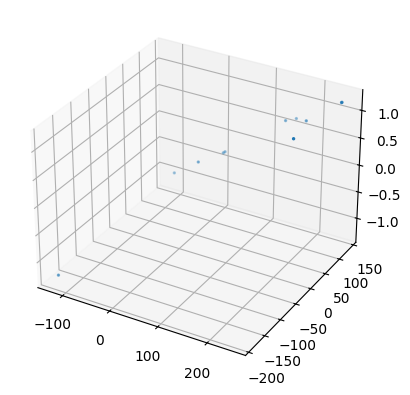

In [21]:
# visualize 3D
from mpl_toolkits.mplot3d import Axes3D  # noqa

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], s=2)
plt.show()